# Badge Holder Tests

 to determine if badges in antistatic / non-antistatic holders behave differently
 
 also checking for variation between badges 
 
 ideally there would be no difference between holder types, or across badges

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
holders_anti = ["EE:B4:AF:3F:05:80", # Badge 262
                "FF:0C:74:ED:C4:CD", # Badge 263
                "EC:FB:84:DE:35:4A", # Badge 264
                "C5:85:B9:18:8D:C3", # Badge 265
                "CB:5C:4B:7C:43:81", # Badge 266
                "E1:07:CE:CE:52:BE"] # Badge 267

In [5]:
holders_noanti = ["F1:4E:55:EA:ED:A4", # Badge 210
                  "E8:FA:0D:3C:01:82", # Badge 211
                  "C2:57:36:E6:71:6E", # Badge 212
                  "D9:86:6F:AF:E8:90", # Badge 213
                  "C1:96:24:5B:EB:97", # Badge 214
                  "C8:2F:80:DA:26:94"] # Badge 215

# Open up the test logs and load into dataframes

In [6]:
# this function parses test data from a file, bounds the RSSI values, and stores them in corresponding DataFrames
# @return - tuple of DataFrames, one for antistatic, regular, and all holders
def load(filename):
    raw = pd.read_csv(filename)
    raw = raw.loc[(raw['RSSI']>-70)]

    at = raw.loc[raw['MAC'].isin(holders_anti)]  # Antistatic Transmitters
    nat = raw.loc[raw['MAC'].isin(holders_noanti)]  # No-Antistatic Transmitters
    allt = pd.concat([at, nat]).sort_values(by="DATETIME")  # All Transmitters (removed unwanted MACs)
    
    return (allt.reset_index(drop=True), at.reset_index(drop=True), nat.reset_index(drop=True))

In [7]:
# Antistatic Receivers
df_ar2, df_ar2at, df_ar2nat = load('logs_antistatic/BLE_range_test_2ft_antistatic_CSV/000.csv')
df_ar4, df_ar4at, df_ar4nat = load('logs_antistatic/BLE_range_test_4ft_antistatic_CSV/000.csv')
df_ar6, df_ar6at, df_ar6nat = load('logs_antistatic/BLE_range_test_6ft_antistatic_CSV/000.csv')
df_ar8, df_ar8at, df_ar8nat = load('logs_antistatic/BLE_range_test_8ft_antistatic_CSV/000.csv')
df_ar10, df_ar10at, df_ar10nat = load('logs_antistatic/BLE_range_test_10ft_antistatic_CSV/000.csv')

In [8]:
# No-Antistatic Receivers
df_nar2, df_nar2at, df_nar2nat = load('logs_noantistatic/BLE_range_test_2ft_noantistatic_CSV/000.csv')
df_nar4, df_nar4at, df_nar4nat = load('logs_noantistatic/BLE_range_test_4ft_noantistatic_CSV/000.csv')
df_nar6, df_nar6at, df_nar6nat = load('logs_noantistatic/BLE_range_test_6ft_noantistatic_CSV/000.csv')
df_nar8, df_nar8at, df_nar8nat = load('logs_noantistatic/BLE_range_test_8ft_noantistatic_CSV/000.csv')
df_nar10, df_nar10at, df_nar10nat = load('logs_noantistatic/BLE_range_test_10ft_noantistatic_CSV/000.csv')

# Make histograms, RSSI vs count

In [9]:
# applies the function "func" on the PANDAS DataFrame "df" with a rolling window of "window"
# computes an aggregate roll for all badges in the DataFrame, not individual
# @return - the resultant DataFrame
def rolling_format(df, window, func):
    roll = df.drop(columns=["DATETIME", "MAC"]).rolling(window)
    if func == "max":
        roll = roll.max()
    elif func == "mean":
        roll = roll.mean()
    return roll.drop(list(range(window))).reset_index(drop=True)
    

In [10]:
def plot_all_distances(holders, roll=None, vert=None, numbins=8, alph=.75):
    h_str = "Holders: " + holders
    r_str = ""
    v_str = ""
    
    if holders == "antistatic":
        df2 = df_ar2at
        df4 = df_ar4at
        df6 = df_ar6at
        df8 = df_ar8at
        df10 = df_ar10at
    elif holders == "regular":
        df2 = df_nar2nat
        df4 = df_nar4nat
        df6 = df_nar6nat
        df8 = df_nar8nat
        df10 = df_nar10nat
        
    if roll:
        roll_window, roll_func = roll
        r_str = ", Roll: " + str(roll_window) + "-wide " + str(roll_func)
        df2 = rolling_format(df2, roll_window, roll_func)
        df4 = rolling_format(df4, roll_window, roll_func)
        df6 = rolling_format(df6, roll_window, roll_func)
        df8 = rolling_format(df8, roll_window, roll_func)
        df10 = rolling_format(df10, roll_window, roll_func)
    
    plt.hist(df2["RSSI"], bins=numbins, alpha=alph, label='2 ft')
    plt.hist(df4["RSSI"], bins=numbins, alpha=alph, label='4 ft')
    plt.hist(df6["RSSI"], bins=numbins, alpha=alph, label='6 ft')
    plt.hist(df8["RSSI"], bins=numbins, alpha=alph, label='8 ft')
    plt.hist(df10["RSSI"], bins=numbins, alpha=alph, label='10 ft')
    
    if vert:
        v_str = ", Vertical: " + str(vert)
        if vert == "max":
            v2 = df2.max()["RSSI"]
            v4 = df4.max()["RSSI"]
            v6 = df6.max()["RSSI"]
            v8 = df8.max()["RSSI"]
            v10 = df10.max()["RSSI"]
        elif vert == "mean":
            v2 = df2.mean()["RSSI"]
            v4 = df4.mean()["RSSI"]
            v6 = df6.mean()["RSSI"]
            v8 = df8.mean()["RSSI"]
            v10 = df10.mean()["RSSI"]
        plt.axvline(x=v2, color='C0')
        plt.axvline(x=v4, color='C1')
        plt.axvline(x=v6, color='C2')
        plt.axvline(x=v8, color='C3')
        plt.axvline(x=v10, color='C4')
    
    plt.title(h_str + r_str + v_str)
    plt.legend(loc='upper left')
    plt.show()

# Raw Data

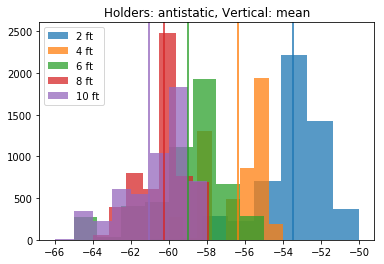

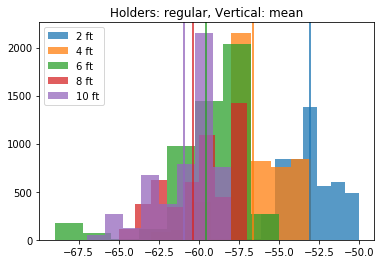

In [11]:
plot_all_distances(holders="antistatic")
plot_all_distances(holders="regular")

# Rolling Mean

In [12]:
WINDOW_SIZE = 5

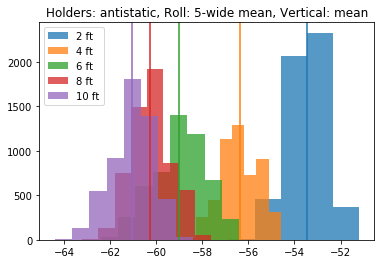

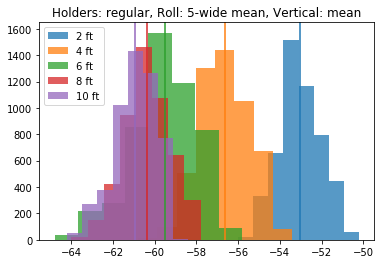

In [13]:
plot_all_distances(holders="antistatic", roll=(WINDOW_SIZE, "mean"), vert="mean")
plot_all_distances(holders="regular", roll=(WINDOW_SIZE, "mean"), vert="mean")

# Rolling Max

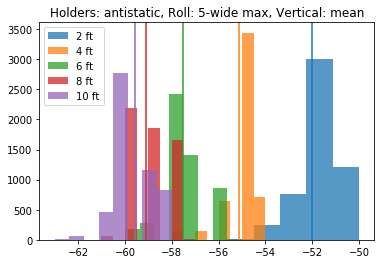

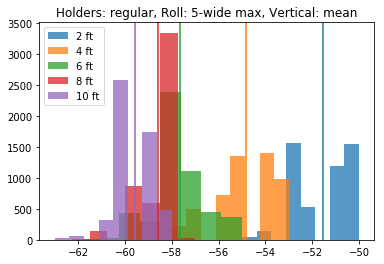

In [14]:
plot_all_distances(holders="antistatic", roll=(WINDOW_SIZE, "max"), vert="mean")
plot_all_distances(holders="regular", roll=(WINDOW_SIZE, "max"), vert="mean")

# Individual badges

In [15]:
dist_to_color = {
    "2ft": "Blues",
    "4ft": "Oranges",
    "6ft": "Greens",
    "8ft": "Reds",
    "10ft": "Purples",
}

In [55]:
def split_roll_plot(holders, dist, roll_func):
    if holders == "antistatic":
        if dist == "2ft":
            df = df_ar2at
        elif dist == "4ft":
            df = df_ar4at
        elif dist == "6ft":
            df = df_ar6at
        elif dist == "8ft":
            df = df_ar8at
        elif dist == "10ft":
            df = df_ar10at
    elif holders == "regular":
        if dist == "2ft":
            df = df_nar2nat
        elif dist == "4ft":
            df = df_nar4nat
        elif dist == "6ft":
            df = df_nar6nat
        elif dist == "8ft":
            df = df_nar8nat
        elif dist == "10ft":
            df = df_nar10nat
    
    # excise all but the relevant data and group by MAC address
    raw = df.drop(columns=["DATETIME"])
    split = raw.groupby("MAC")
    
    # compute func over the rolling window
    if roll_func == "mean":
        roll = split.rolling(WINDOW_SIZE).mean()
    else:
        roll = split.rolling(WINDOW_SIZE).max()
    plot_bounds = (roll["RSSI"].min()-4, roll["RSSI"].max()+1)

    # finishing touches to get it in a form that PANDAS will plot properly
    roll = roll.drop(columns=["MAC"]).reset_index().drop(columns=["level_1"])
    refined = roll.reset_index().pivot("index", "MAC", "RSSI")

    var = refined.apply(np.mean).var()
    refined.plot.hist(bins=10, 
                      xlim=(-68, -50), 
                      colormap=dist_to_color[dist], 
                      title=dist + " " + holders 
                                + ", " + str(WINDOW_SIZE) + "-wide " + roll_func 
                                + ", var: " + str("%.4f" % var))


## Antistatic Holders

#### Rolling Mean

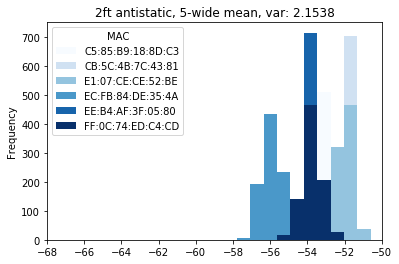

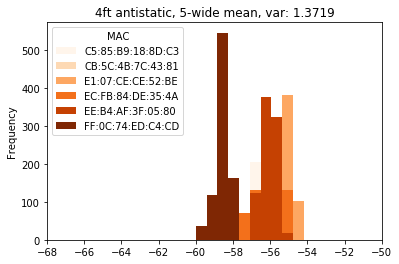

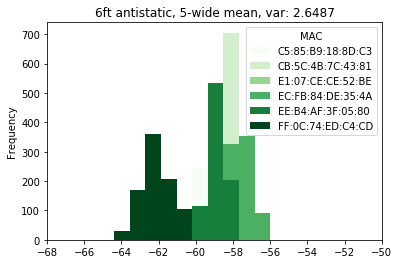

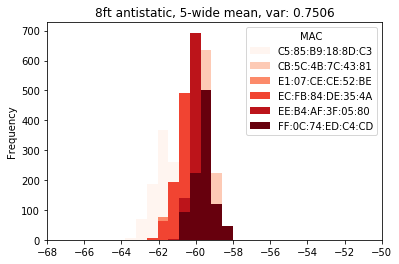

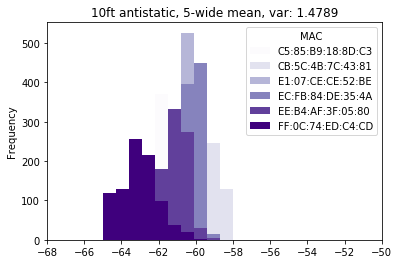

In [57]:
split_roll_plot("antistatic", "2ft", "mean")
split_roll_plot("antistatic", "4ft", "mean")
split_roll_plot("antistatic", "6ft", "mean")
split_roll_plot("antistatic", "8ft", "mean")
split_roll_plot("antistatic", "10ft", "mean")

#### Rolling Max

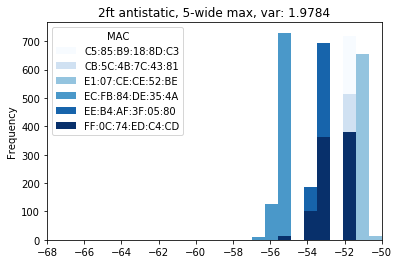

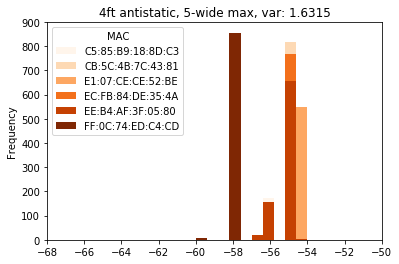

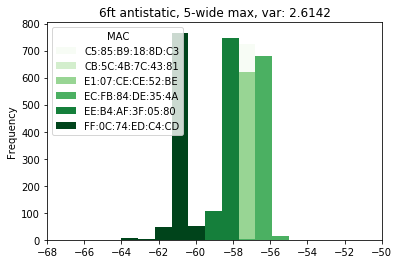

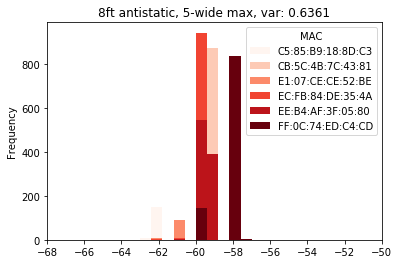

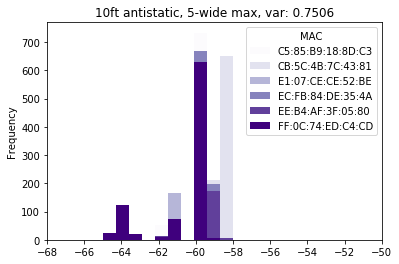

In [58]:
split_roll_plot("antistatic", "2ft", "max")
split_roll_plot("antistatic", "4ft", "max")
split_roll_plot("antistatic", "6ft", "max")
split_roll_plot("antistatic", "8ft", "max")
split_roll_plot("antistatic", "10ft", "max")

## Regular Holders

#### Rolling Mean

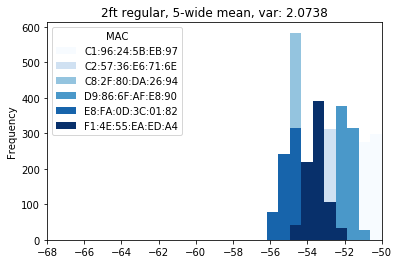

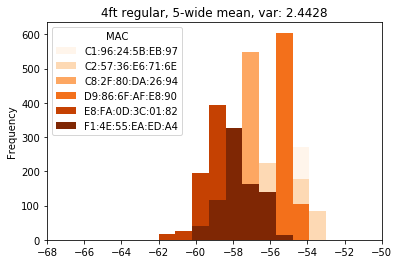

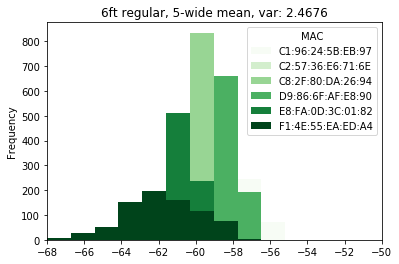

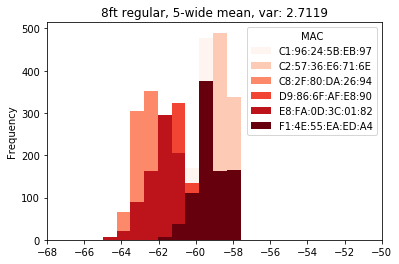

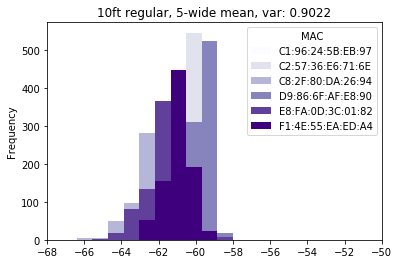

In [59]:
split_roll_plot("regular", "2ft", "mean")
split_roll_plot("regular", "4ft", "mean")
split_roll_plot("regular", "6ft", "mean")
split_roll_plot("regular", "8ft", "mean")
split_roll_plot("regular", "10ft", "mean")

#### Rolling Max

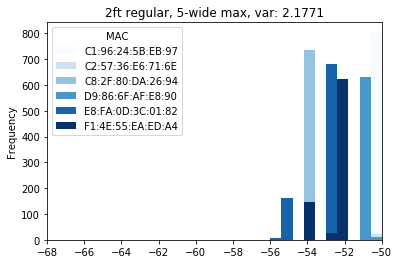

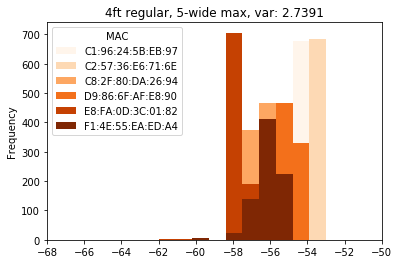

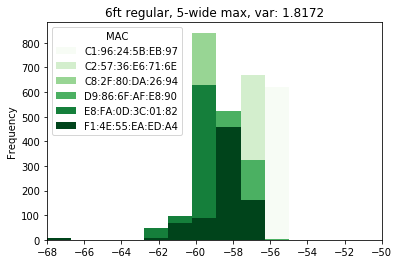

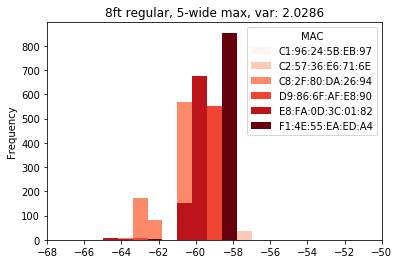

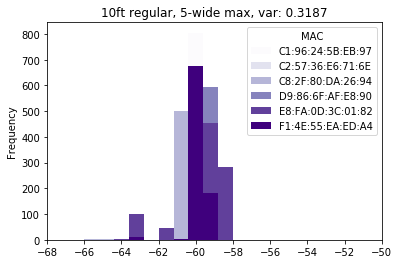

In [60]:
split_roll_plot("regular", "2ft", "max")
split_roll_plot("regular", "4ft", "max")
split_roll_plot("regular", "6ft", "max")
split_roll_plot("regular", "8ft", "max")
split_roll_plot("regular", "10ft", "max")